In [23]:
!pip install pandas seaborn matplotlib beautifulsoup4 lxml openpyxl

In [24]:
import pandas as pd
from bs4 import BeautifulSoup
import os

# --- AYARLAR ---
# XML dosyanızın tam adını buraya yazın (Örn: 'Costantinopoli.xml')
DOSYA_ADI = "Costantinopoli.xml"  

def veri_getir(xml_yolu):
    if not os.path.exists(xml_yolu):
        print(f"HATA: '{xml_yolu}' dosyası bulunamadı!")
        return pd.DataFrame()

    with open(xml_yolu, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    veri_listesi = []
    
    # Bölümleri (Capitolo) Bulalım
    bolumler = soup.find_all("div", type="capitolo")
    if not bolumler:
        print("Bilgi: 'capitolo' etiketi bulunamadı, tüm metin tek parça işleniyor.")
        bolumler = [soup.body]

    for bolum_no, bolum in enumerate(bolumler, 1):
        # Her paragrafı (<p>) tek tek geziyoruz
        paragraflar = bolum.find_all("p")
        
        for p in paragraflar:
            # Paragraf içindeki Mekanları ve Etnik Grupları topla
            mekanlar = [pl.get("ref", pl.get_text()) for pl in p.find_all("placeName")]
            etnikler = [rs.get("key", rs.get_text()) for rs in p.find_all("rs", type="ethnic")]
            
            # ÇAPRAZ EŞLEŞTİRME (Co-occurrence)
            # Eğer aynı paragrafta hem mekan hem etnik grup varsa bunları eşleştir
            if mekanlar and etnikler:
                for mek in mekanlar:
                    for etn in etnikler:
                        veri_listesi.append({
                            "Bölüm": bolum_no,
                            "Mekan": mek,
                            "Etnik": etn,
                            "Tip": "Mekan-Etnik İlişkisi"
                        })
            
            # Sadece Etnik Grupların Bölüm Dağılımı İçin (Mekan olmasa da kaydet)
            elif etnikler: 
                for etn in etnikler:
                    veri_listesi.append({
                        "Bölüm": bolum_no,
                        "Mekan": "Belirsiz", # Mekan yoksa
                        "Etnik": etn,
                        "Tip": "Sadece Etnik"
                    })

    df = pd.DataFrame(veri_listesi)
    return df

# Fonksiyonu çalıştır ve veriyi hafızaya al
print("XML dosyası okunuyor ve analiz ediliyor...")
df_ana = veri_getir(DOSYA_ADI)

if not df_ana.empty:
    print(f"✅ İŞLEM BAŞARILI! Toplam {len(df_ana)} veri satırı çıkarıldı.")
    # Veriyi Excel'e yedekle (Makale ekine koymak için)
    df_ana.to_excel("Ham_Veriler.xlsx", index=False)
    print("📂 Veriler 'Ham_Veriler.xlsx' olarak kaydedildi.")
else:
    print("⚠️ Veri çıkarılamadı. XML yapısını veya dosya adını kontrol et.")

XML dosyası okunuyor ve analiz ediliyor...
✅ İŞLEM BAŞARILI! Toplam 9982 veri satırı çıkarıldı.
📂 Veriler 'Ham_Veriler.xlsx' olarak kaydedildi.


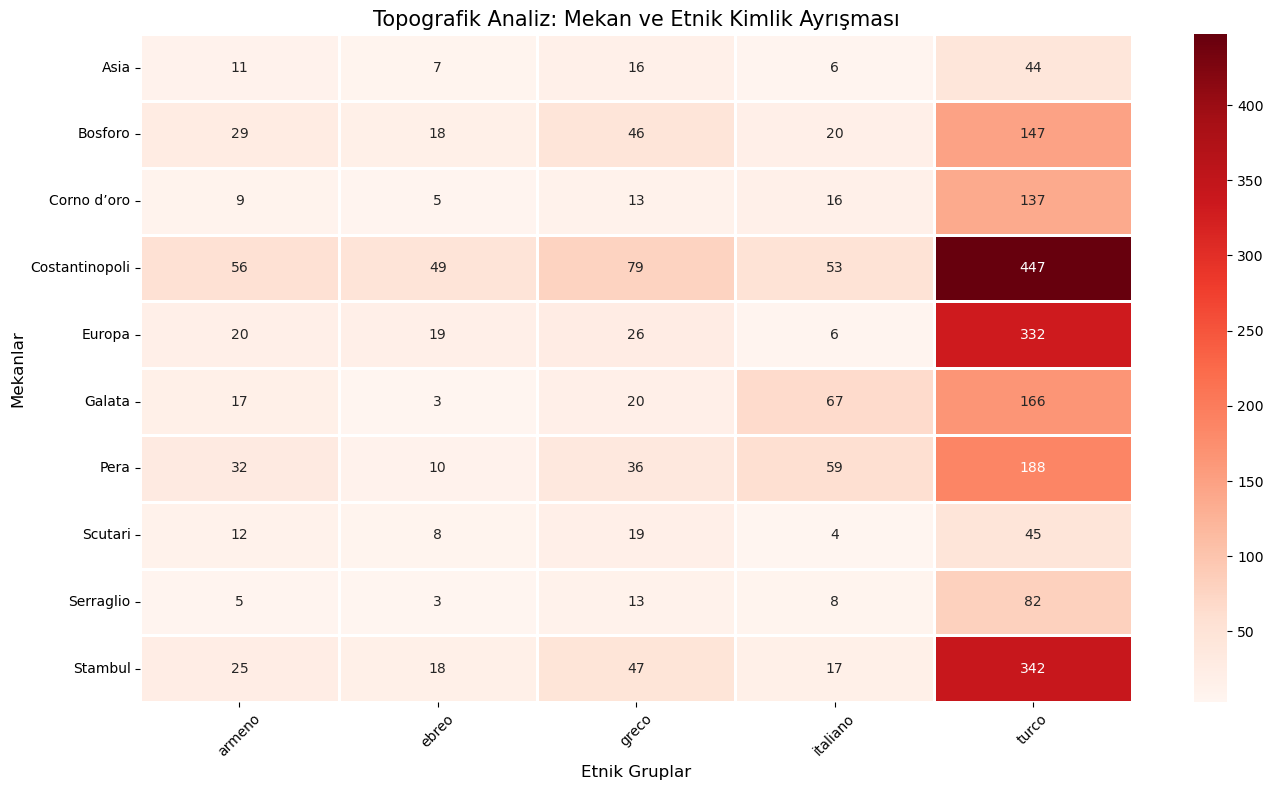

Grafik 'Analiz_1_Mekansal_Isi_Haritasi.png' adıyla kaydedildi.


In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Sadece Mekan-Etnik ilişkisi olan satırları alalım
df_mekan = df_ana[df_ana["Tip"] == "Mekan-Etnik İlişkisi"]

if not df_mekan.empty:
    # Gürültüyü azaltmak için en çok geçen ilk 15 Mekan ve ilk 10 Etnik grubu alalım
    top_mekanlar = df_mekan["Mekan"].value_counts().head(10).index
    top_etnik = df_mekan["Etnik"].value_counts().head(5).index
    
    # Veriyi filtrele
    df_filtered = df_mekan[df_mekan["Mekan"].isin(top_mekanlar) & df_mekan["Etnik"].isin(top_etnik)]
    
    # Çapraz Tablo Oluştur (Heatmap için gerekli format)
    heatmap_data = pd.crosstab(df_filtered["Mekan"], df_filtered["Etnik"])

    # GRAFİĞİ ÇİZ
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Reds", linewidths=1, linecolor='white')
    
    plt.title("Topografik Analiz: Mekan ve Etnik Kimlik Ayrışması", fontsize=15)
    plt.ylabel("Mekanlar", fontsize=12)
    plt.xlabel("Etnik Gruplar", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Kaydet
    plt.savefig("Analiz_1_Mekansal_Isi_Haritasi.png", dpi=300)
    plt.show()
    print("Grafik 'Analiz_1_Mekansal_Isi_Haritasi.png' adıyla kaydedildi.")
else:
    print("Analiz yapılacak veri bulunamadı.")

In [26]:
import pandas as pd
from bs4 import BeautifulSoup
import os

# --- AYARLAR ---
# XML dosyanızın tam adını buraya yazın
DOSYA_ADI = "Costantinopoli.xml"  

def etnik_sayim_yap(xml_yolu):
    if not os.path.exists(xml_yolu):
        print(f"HATA: '{xml_yolu}' dosyası bulunamadı!")
        return

    with open(xml_yolu, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    etnik_listesi = []
    
    # Tüm etnik etiketleri bul: <rs type="ethnic">
    # Hem 'key' (standart hali) hem de metindeki orijinal halini alabiliriz.
    # Analiz için 'key' değerini saymak daha doğrudur (turco, greco vs.)
    tum_etnikler = soup.find_all("rs", type="ethnic")
    
    for rs in tum_etnikler:
        key_degeri = rs.get("key", "Belirsiz") # key yoksa "Belirsiz" yazar
        orijinal_metin = rs.get_text()
        etnik_listesi.append(key_degeri)

    # Listeyi Pandas Serisine çevirip saydıralım
    s_etnik = pd.Series(etnik_listesi)
    
    # SONUÇLARI HESAPLA
    toplam_atif = len(s_etnik)
    farkli_irk_sayisi = s_etnik.nunique()
    frekans_tablosu = s_etnik.value_counts()

    print("="*40)
    print(f"📊 ETNİK UNSUR FREKANS ANALİZİ RAPORU")
    print("="*40)
    print(f"• Toplam Etnik Atıf Sayısı (Mention): {toplam_atif}")
    print(f"• Tespit Edilen Farklı Etnik Grup Sayısı: {farkli_irk_sayisi}")
    print("-" * 40)
    print("Sıralı Liste (En Çoktan En Aza):")
    print("-" * 40)
    print(frekans_tablosu)
    
    # İlk 10'u bir liste olarak verelim ki kopyalayıp diğer koda yapıştırabilesin
    ilk_10_liste = frekans_tablosu.head(10).index.tolist()
    print("-" * 40)
    print(f"🏆 ANALİZDE KULLANILACAK İLK 10 GRUP (Kopyalanabilir Liste):")
    print(ilk_10_liste)
    print("="*40)
    
    # İstersen Excel'e de kaydedelim
    frekans_tablosu.to_excel("Etnik_Frekans_Listesi.xlsx")
    print("Detaylı liste 'Etnik_Frekans_Listesi.xlsx' dosyasına kaydedildi.")

# Çalıştır
etnik_sayim_yap(DOSYA_ADI)

📊 ETNİK UNSUR FREKANS ANALİZİ RAPORU
• Toplam Etnik Atıf Sayısı (Mention): 662
• Tespit Edilen Farklı Etnik Grup Sayısı: 50
----------------------------------------
Sıralı Liste (En Çoktan En Aza):
----------------------------------------
turco           330
greco            78
italiano         43
armeno           35
ebreo            25
francese         19
arabo            16
persiano         12
circasso         10
russo             9
inglese           8
zingaro           7
bulgaro           6
bizantino         6
tartaro           5
siriano           3
ungherese         3
cosacco           3
goto              3
albanese          3
avaro             3
abissino          2
georgiano         2
serbo             2
valacco           2
egiziano          2
caucasico         2
gothos            1
turcomanno        1
spagnolo          1
caucaseo          1
vandalo           1
romano            1
moresco           1
slavo             1
austriaco         1
arnauto           1
tunisino          1
a

Veriler analiz ediliyor, lütfen bekleyin...
✅ Analiz Tamamlandı! Toplam 577 veri noktası görselleştiriliyor.


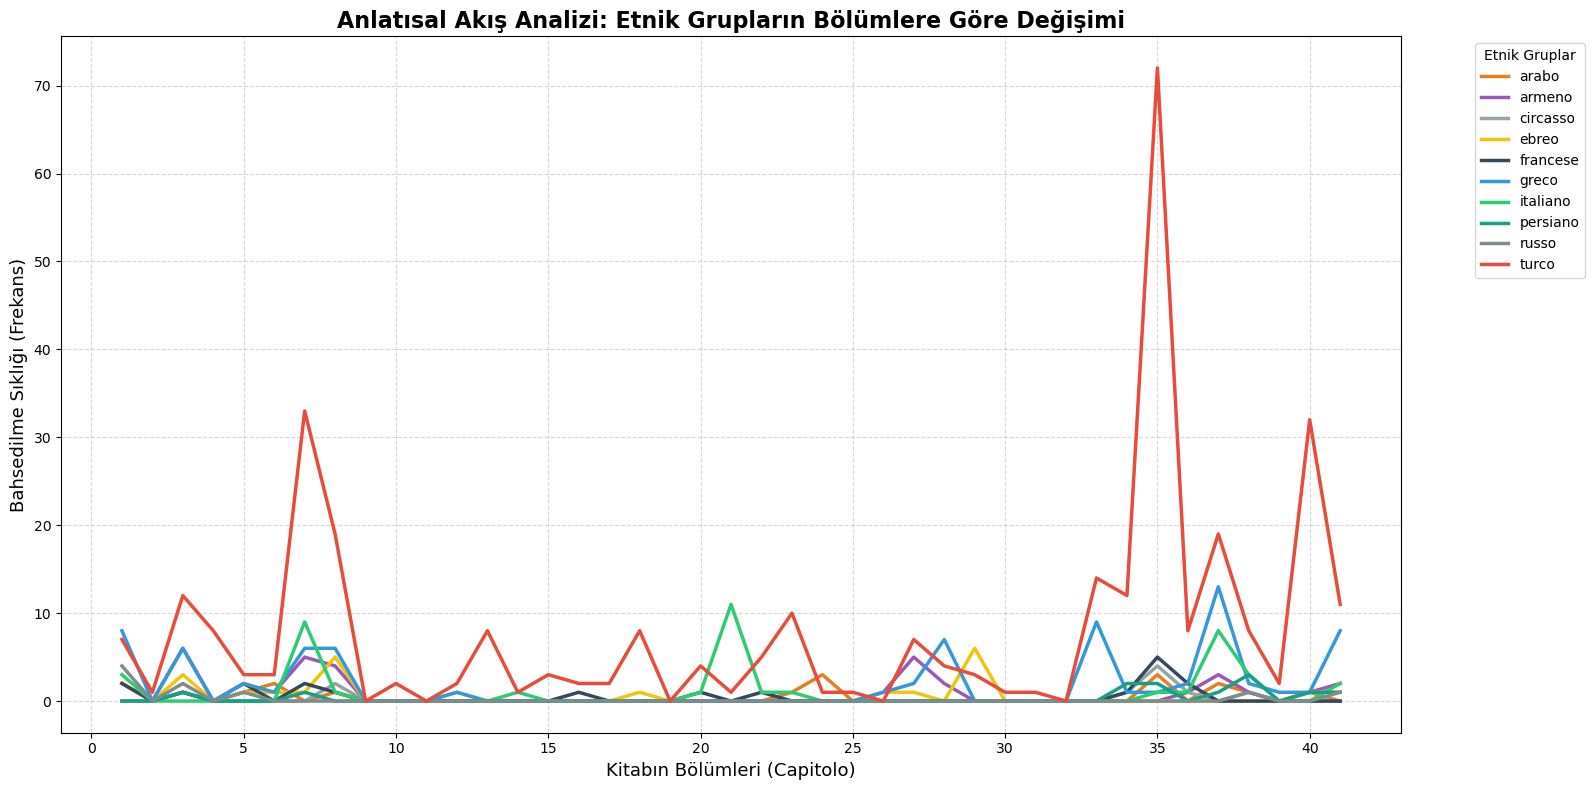

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# -----------------------------------------------------------------------------
# 1. AYARLAR VE HEDEF LİSTE
# -----------------------------------------------------------------------------
# XML dosyanızın tam adı
DOSYA_ADI = "Costantinopoli.xml"  

# Analizden elde ettiğimiz İLK 10 ETNİK GRUP (Senin verine göre sabitlendi)
hedef_gruplar = [
    "turco",      # 330
    "greco",      # 78
    "italiano",   # 43
    "armeno",     # 35
    "ebreo",      # 25
    "francese",   # 19
    "arabo",      # 16
    "persiano",   # 12
    "circasso",   # 10
    "russo"       # 9
]

# Renk Paleti (Grafiklerin daha akademik ve ayırt edici görünmesi için)
# Türkler için kırmızı, diğerleri için farklı tonlar
ozel_renkler = {
    "turco": "#e74c3c",    # Kırmızı
    "greco": "#3498db",    # Mavi
    "italiano": "#2ecc71", # Yeşil
    "armeno": "#9b59b6",   # Mor
    "ebreo": "#f1c40f",    # Sarı
    "francese": "#34495e", # Koyu Lacivert
    "arabo": "#e67e22",    # Turuncu
    "persiano": "#16a085", # Turkuaz
    "circasso": "#95a5a6", # Gri
    "russo": "#7f8c8d"     # Koyu Gri
}

# -----------------------------------------------------------------------------
# 2. VERİ MADENCİLİĞİ (XML OKUMA)
# -----------------------------------------------------------------------------
def veri_hazirla(dosya_yolu):
    if not os.path.exists(dosya_yolu):
        print(f"HATA: '{dosya_yolu}' bulunamadı.")
        return pd.DataFrame()

    with open(dosya_yolu, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    veri = []
    
    # Bölümleri (Capitolo) Bul
    bolumler = soup.find_all("div", type="capitolo")
    if not bolumler:
        print("UYARI: 'capitolo' etiketi bulunamadı, tüm metin tek parça işleniyor.")
        bolumler = [soup.body]

    for bolum_no, bolum in enumerate(bolumler, 1):
        # Sadece hedef listedeki etnik grupları topla
        etnikler = bolum.find_all("rs", type="ethnic")
        for rs in etnikler:
            key = rs.get("key", rs.get_text())
            if key in hedef_gruplar:
                veri.append({
                    "Bölüm": bolum_no,
                    "Etnik": key
                })
    
    return pd.DataFrame(veri)

print("Veriler analiz ediliyor, lütfen bekleyin...")
df = veri_hazirla(DOSYA_ADI)

if not df.empty:
    print(f"✅ Analiz Tamamlandı! Toplam {len(df)} veri noktası görselleştiriliyor.")
    
    # -----------------------------------------------------------------------------
    # 3. GÖRSELLEŞTİRME 1: ANLATISAL AKIŞ (NARRATIVE FLOW - LINE CHART)
    # -----------------------------------------------------------------------------
    # Veriyi 'Bölüm' ve 'Etnik' bazında gruplayıp sayalım
    akis_verisi = pd.crosstab(df["Bölüm"], df["Etnik"])
    
    # Eksik bölümler varsa 0 ile doldur (Grafik kopuk olmasın)
    akis_verisi = akis_verisi.reindex(range(1, df["Bölüm"].max() + 1), fill_value=0)

    plt.figure(figsize=(16, 8))
    
    # Her bir ırk için çizgi çiz
    sns.lineplot(data=akis_verisi, dashes=False, palette=ozel_renkler, linewidth=2.5)
    
    plt.title("Anlatısal Akış Analizi: Etnik Grupların Bölümlere Göre Değişimi", fontsize=16, fontweight='bold')
    plt.xlabel("Kitabın Bölümleri (Capitolo)", fontsize=13)
    plt.ylabel("Bahsedilme Sıklığı (Frekans)", fontsize=13)
    plt.legend(title="Etnik Gruplar", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Kaydet
    plt.savefig("Analiz_Narrative_Flow.png", dpi=300)
    plt.show()
    print("Grafik 1: 'Analiz_Narrative_Flow.png' olarak kaydedildi.")

    # -----------------------------------------------------------------------------
    # 4. GÖRSELLEŞTİRME 2: TOPLAM DAĞILIM (BAR CHART)
    # -----------------------------------------------------------------------------
    plt.figure(figsize=(12, 6))
    
    # Sıralamayı koruyarak say
    toplam_sayilar = df["Etnik"].value_counts().reindex(hedef_gruplar)
    
    sns.barplot(x=toplam_sayilar.index, y=toplam_sayilar.values, palette=ozel_renkler)
    
    plt.title("Eserde En Çok Yer Alan İlk 10 Etnik Grup (Genel Dağılım)", fontsize=15)
    plt.ylabel("Toplam Atıf Sayısı", fontsize=12)
    plt.xlabel("Etnik Gruplar", fontsize=12)
    plt.xticks(rotation=45)
    
    # Çubukların üzerine sayıları yaz
    for i, v in enumerate(toplam_sayilar.values):
        plt.text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig("Analiz_Top10_BarChart.png", dpi=300)
    plt.show()
    print("Grafik 2: 'Analiz_Top10_BarChart.png' olarak kaydedildi.")
    
    # Veriyi Excel'e de atalım
    akis_verisi.to_excel("Bolum_Bazli_Etnik_Dagilim.xlsx")
    print("📂 Veri Dosyası: 'Bolum_Bazli_Etnik_Dagilim.xlsx' oluşturuldu.")

else:
    print("⚠️ HATA: XML dosyasından hiç veri çekilemedi. Dosya adını ve etiketleri kontrol et.")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# -----------------------------------------------------------------------------
# 1. AYARLAR
# -----------------------------------------------------------------------------
DOSYA_ADI = "Costantinopoli.xml"  # XML dosyanızın tam adı

# -----------------------------------------------------------------------------
# 2. VERİ MADENCİLİĞİ (GENEL TÜR ANALİZİ)
# -----------------------------------------------------------------------------
def genel_tur_analizi(dosya_yolu):
    if not os.path.exists(dosya_yolu):
        print(f"HATA: '{dosya_yolu}' dosyası bulunamadı!")
        return pd.DataFrame()

    with open(dosya_yolu, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    veri_listesi = []
    
    # Tüm mekan etiketlerini bul
    mekanlar = soup.find_all("placeName")
    
    for mekan in mekanlar:
        # Mekan Türünü Al (type özniteliği)
        # XML'de type="sacred", type="building", type="infrastructure" değerleri var.
        raw_type = mekan.get("type", "Belirsiz").lower()
        
        # Sadece sizin promptunuzda belirttiğiniz 3 ana kategoriye göre sınıflandırma
        if "sacred" in raw_type:
            tur = "Kutsal (Sacred)"
        elif "building" in raw_type:
            tur = "Bina (Building)"
        elif "infrastructure" in raw_type:
            tur = "Altyapı (Infrastructure)"
        elif "belirsiz" in raw_type or raw_type == "":
            tur = "Genel (Tip Belirtilmemiş)"
        else:
            # Nadiren başka bir şey yazıldıysa 'Diğer' kategorisine alalım
            tur = "Diğer"
        
        # 'Genel' veya 'Diğer' olanları analize katmak isteyip istemediğinize göre
        # aşağıdaki if koşulunu düzenleyebilirsiniz. 
        # Şu an sadece net etiketi olanları (Sacred, Building, Infrastructure) alıyoruz.
        target_types = ["Kutsal (Sacred)", "Bina (Building)", "Altyapı (Infrastructure)"]
        
        if tur in target_types:
            veri_listesi.append({
                "Tür": tur
            })

    return pd.DataFrame(veri_listesi)

# Analizi Çalıştır
print("Yapıt genelinde mekan türleri analiz ediliyor...")
df_tur = genel_tur_analizi(DOSYA_ADI)

if not df_tur.empty:
    print(f"✅ Analiz Başarılı! Toplam {len(df_tur)} sınıflandırılmış mekan verisi bulundu.")
    
    # -----------------------------------------------------------------------------
    # 3. GÖRSELLEŞTİRME: GENEL DAĞILIM (BAR CHART)
    # -----------------------------------------------------------------------------
    plt.figure(figsize=(10, 6))
    
    # Türlere göre sayım yap ve çoktan aza sırala
    tur_sayilari = df_tur["Tür"].value_counts().reset_index()
    tur_sayilari.columns = ["Tür", "Sayı"]
    
    # Seaborn ile çizim
    # Renkleri belirginleştirelim: Kutsal (Kırmızımsı), Bina (Mavi), Altyapı (Yeşil/Gri)
    custom_palette = {
        "Kutsal (Sacred)": "#e74c3c",       # Kırmızı
        "Bina (Building)": "#3498db",       # Mavi
        "Altyapı (Infrastructure)": "#95a5a6" # Gri
    }
    
    ax = sns.barplot(data=tur_sayilari, x="Tür", y="Sayı", palette=custom_palette)
    
    # Başlık ve Etiketler
    plt.title("Costantinopoli Eserinde Mekan Türlerinin Dağılımı", fontsize=15, fontweight='bold')
    plt.ylabel("Atıf Sayısı (Frekans)", fontsize=12)
    plt.xlabel("Mekan Türü", fontsize=12)
    
    # Çubukların üzerine sayıları yaz (Net okunabilirlik için)
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha = 'center', va = 'center', 
                    xytext = (0, 9), 
                    textcoords = 'offset points',
                    fontweight='bold')

    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Grafiği Kaydet
    plt.savefig("Analiz_Genel_Mekan_Turleri.png", dpi=300)
    plt.show()
    print("Grafik 'Analiz_Genel_Mekan_Turleri.png' olarak kaydedildi.")
    
    # İstatistiksel Tabloyu Excel'e Kaydet
    print("\nSayısal Dağılım Tablosu:")
    print(tur_sayilari)
    tur_sayilari.to_excel("Genel_Mekan_Turu_Dagilimi.xlsx", index=False)
    print("Veriler 'Genel_Mekan_Turu_Dagilimi.xlsx' dosyasına kaydedildi.")

else:
    print("⚠️ Veri bulunamadı. XML dosyasında 'sacred', 'building' veya 'infrastructure' tiplerinin olduğundan emin olun.")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# 1. AYARLAR
DOSYA_ADI = "Costantinopoli.xml"

# 2. VERİ MADENCİLİĞİ
def detayli_mekan_analizi(dosya_yolu):
    if not os.path.exists(dosya_yolu):
        print("Dosya bulunamadı!")
        return pd.DataFrame(), pd.DataFrame()

    with open(dosya_yolu, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    yogunluk_verisi = []
    iliski_verisi = []

    # Bölümleri Bul
    bolumler = soup.find_all("div", type="capitolo")
    if not bolumler:
        bolumler = [soup.body] # Bölüm yoksa tek parça al

    for bolum_no, bolum in enumerate(bolumler, 1):
        # A. YOĞUNLUK İÇİN: Bu bölümdeki toplam mekan sayısını bul
        mekanlar = bolum.find_all("placeName")
        yogunluk_verisi.append({
            "Bölüm": bolum_no,
            "Mekan Sayısı": len(mekanlar)
        })

        # B. KİŞİ-MEKAN İLİŞKİSİ İÇİN: Paragraf bazlı tarama
        paragraflar = bolum.find_all("p")
        for p in paragraflar:
            p_mekanlar = [m.get("ref", m.get_text()) for m in p.find_all("placeName")]
            p_kisiler = [per.get_text() for per in p.find_all("persName")]

            # Eğer aynı paragrafta hem mekan hem kişi varsa eşleştir
            if p_mekanlar and p_kisiler:
                for mek in p_mekanlar:
                    for kisi in p_kisiler:
                        iliski_verisi.append({
                            "Mekan": mek,
                            "Kişi": kisi
                        })

    return pd.DataFrame(yogunluk_verisi), pd.DataFrame(iliski_verisi)

# Analizi Çalıştır
print("Ek analizler yapılıyor...")
df_yogunluk, df_iliski = detayli_mekan_analizi(DOSYA_ADI)

if not df_yogunluk.empty:
    
    # --- GRAFİK 1: MEKANSAL YOĞUNLUK (DESCRIPTIVE RHYTHM) ---
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_yogunluk, x="Bölüm", y="Mekan Sayısı", marker="o", linewidth=2.5, color="#d35400")
    plt.title("Eserin Betimsel Ritmi: Bölümlere Göre Mekan Atıf Yoğunluğu", fontsize=14)
    plt.xlabel("Bölüm (Capitolo)", fontsize=12)
    plt.ylabel("Bahsedilen Mekan Sayısı", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("Analiz_4_Mekansal_Yogunluk.png", dpi=300)
    plt.show()
    print("Grafik 1 (Yoğunluk) kaydedildi.")

    # --- GRAFİK 2: KİŞİ-MEKAN AĞI (HEATMAP) ---
    if not df_iliski.empty:
        # Veri çoksa grafik karışır, en çok geçen 10 kişi ve 10 mekanı alalım
        top_mekan = df_iliski["Mekan"].value_counts().head(10).index
        top_kisi = df_iliski["Kişi"].value_counts().head(10).index
        
        df_filtered = df_iliski[df_iliski["Mekan"].isin(top_mekan) & df_iliski["Kişi"].isin(top_kisi)]
        
        if not df_filtered.empty:
            heatmap_data = pd.crosstab(df_filtered["Mekan"], df_filtered["Kişi"])
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", linewidths=1)
            plt.title("Beşeri Coğrafya: Kim Hangi Mekanla Anılıyor?", fontsize=14)
            plt.ylabel("Mekanlar")
            plt.xlabel("Kişiler")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig("Analiz_5_Kisi_Mekan_Iliskisi.png", dpi=300)
            plt.show()
            print("Grafik 2 (Kişi-Mekan) kaydedildi.")
        else:
            print("Yeterli kesişim verisi bulunamadı.")
    else:
        print("Kişi ve mekanın aynı anda geçtiği paragraf bulunamadı.")
        
    # Excel Çıktısı
    df_yogunluk.to_excel("Bolum_Mekan_Yogunlugu.xlsx", index=False)

else:
    print("Veri bulunamadı.")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# 1. SETTINGS
DOSYA_ADI = "Costantinopoli.xml"

# 2. DATA MINING
def detayli_mekan_analizi(dosya_yolu):
    if not os.path.exists(dosya_yolu):
        print("File not found!")
        return pd.DataFrame(), pd.DataFrame()

    with open(dosya_yolu, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    yogunluk_verisi = []
    iliski_verisi = []

    # Find Chapters
    bolumler = soup.find_all("div", type="capitolo")
    if not bolumler:
        bolumler = [soup.body] 

    for bolum_no, bolum in enumerate(bolumler, 1):
        # A. FOR DENSITY: Total place count in this chapter
        mekanlar = bolum.find_all("placeName")
        yogunluk_verisi.append({
            "Chapter": bolum_no,            # İngilizce Anahtar
            "Place Count": len(mekanlar)    # İngilizce Anahtar
        })

        # B. PERSON-PLACE RELATION: Paragraph scanning
        paragraflar = bolum.find_all("p")
        for p in paragraflar:
            p_mekanlar = [m.get("ref", m.get_text()) for m in p.find_all("placeName")]
            p_kisiler = [per.get_text() for per in p.find_all("persName")]

            if p_mekanlar and p_kisiler:
                for mek in p_mekanlar:
                    for kisi in p_kisiler:
                        iliski_verisi.append({
                            "Place": mek,    # İngilizce Anahtar
                            "Person": kisi   # İngilizce Anahtar
                        })

    return pd.DataFrame(yogunluk_verisi), pd.DataFrame(iliski_verisi)

# Run Analysis
print("Running additional analyses...")
df_yogunluk, df_iliski = detayli_mekan_analizi(DOSYA_ADI)

if not df_yogunluk.empty:
    
    # --- GRAPH 1: SPATIAL DENSITY (DESCRIPTIVE RHYTHM) ---
    plt.figure(figsize=(12, 6))
    # Buradaki x ve y değerleri yukarıdaki "İngilizce Anahtar"larla birebir aynı olmalı
    sns.lineplot(data=df_yogunluk, x="Chapter", y="Place Count", marker="o", linewidth=2.5, color="#d35400")
    
    plt.title("Descriptive Rhythm: Density of Place References by Chapter", fontsize=14)
    plt.xlabel("Chapter (Capitolo)", fontsize=12)
    plt.ylabel("Number of Places Mentioned", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("Analysis_4_Spatial_Density.png", dpi=300)
    plt.show()
    print("Graph 1 (Density) saved.")

    # --- GRAPH 2: PERSON-PLACE NETWORK (HEATMAP) ---
    if not df_iliski.empty:
        # Filter top 10 for readability
        top_mekan = df_iliski["Place"].value_counts().head(10).index
        top_kisi = df_iliski["Person"].value_counts().head(10).index
        
        df_filtered = df_iliski[df_iliski["Place"].isin(top_mekan) & df_iliski["Person"].isin(top_kisi)]
        
        if not df_filtered.empty:
            # Crosstab keys must match dataframe columns
            heatmap_data = pd.crosstab(df_filtered["Place"], df_filtered["Person"])
            
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Blues", linewidths=1)
            plt.title("Human Geography: Person-Place Associations", fontsize=14)
            plt.ylabel("Places")
            plt.xlabel("People")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.savefig("Analysis_5_Person_Place_Relation.png", dpi=300)
            plt.show()
            print("Graph 2 (Person-Place) saved.")
        else:
            print("Not enough intersection data found.")
    else:
        print("No paragraphs found containing both a person and a place.")
        
    # Excel Output
    df_yogunluk.to_excel("Chapter_Place_Density.xlsx", index=False)

else:
    print("No data found.")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# -----------------------------------------------------------------------------
# 1. SETTINGS
# -----------------------------------------------------------------------------
DOSYA_ADI = "Costantinopoli.xml"  # Your XML file name

# -----------------------------------------------------------------------------
# 2. DATA MINING (PLACE - ETHNIC CO-OCCURRENCE)
# -----------------------------------------------------------------------------
def get_spatial_segregation_data(file_path):
    if not os.path.exists(file_path):
        print(f"ERROR: '{file_path}' not found!")
        return pd.DataFrame()

    with open(file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    data_list = []
    
    # Find Chapters (Capitolo)
    chapters = soup.find_all("div", type="capitolo")
    if not chapters:
        chapters = [soup.body]

    for chapter in chapters:
        # Iterate through paragraphs
        paragraphs = chapter.find_all("p")
        
        for p in paragraphs:
            # Extract Places (using 'ref' if available, else text)
            places = [pl.get("ref", pl.get_text()) for pl in p.find_all("placeName")]
            # Extract Ethnic Groups (using 'key' if available, else text)
            ethnics = [rs.get("key", rs.get_text()) for rs in p.find_all("rs", type="ethnic")]
            
            # CO-OCCURRENCE LOGIC
            # If a paragraph contains both a place and an ethnic group, link them.
            if places and ethnics:
                for place in places:
                    for ethnic in ethnics:
                        data_list.append({
                            "Place": place,
                            "Ethnic Group": ethnic
                        })
            
    return pd.DataFrame(data_list)

# Run Analysis
print("Analyzing spatial segregation...")
df_segregation = get_spatial_segregation_data(DOSYA_ADI)

if not df_segregation.empty:
    print(f"✅ Analysis Successful! Total {len(df_segregation)} associations found.")
    
    # -----------------------------------------------------------------------------
    # 3. VISUALIZATION: HEATMAP
    # -----------------------------------------------------------------------------
    
    # Filter for readability: Top 15 Places and Top 10 Ethnic Groups
    top_places = df_segregation["Place"].value_counts().head(10).index
    top_ethnics = df_segregation["Ethnic Group"].value_counts().head(5).index
    
    # Filter Data
    df_filtered = df_segregation[
        df_segregation["Place"].isin(top_places) & 
        df_segregation["Ethnic Group"].isin(top_ethnics)
    ]
    
    # Create Cross-Tabulation
    heatmap_data = pd.crosstab(df_filtered["Place"], df_filtered["Ethnic Group"])

    # DRAW GRAPH
    plt.figure(figsize=(14, 8))
    sns.heatmap(heatmap_data, annot=True, fmt="d", cmap="Reds", linewidths=1, linecolor='white')
    
    # ENGLISH TITLES AND LABELS
    plt.title("Topographic Analysis: Spatial Segregation of Ethnic Identity", fontsize=15, fontweight='bold')
    plt.ylabel("Places (Most Frequent)", fontsize=12)
    plt.xlabel("Ethnic / Religious Groups", fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Save Graph
    plt.savefig("Analysis_Spatial_Segregation.png", dpi=300)
    plt.show()
    print("Graph saved as 'Analysis_Spatial_Segregation.png'.")
    
    # Save Excel for Report
    heatmap_data.to_excel("Spatial_Segregation_Data.xlsx")
    print("Data saved to 'Spatial_Segregation_Data.xlsx'.")

else:
    print("⚠️ No data found. Please check your XML file path and tags.")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# -----------------------------------------------------------------------------
# 1. SETTINGS AND TARGET LIST
# -----------------------------------------------------------------------------
# Full name of your XML file
DOSYA_ADI = "Costantinopoli.xml"  

# TOP 10 ETHNIC GROUPS (Fixed based on your data)
# Note: Keep the keys (turco, greco etc.) as they appear in the XML
hedef_gruplar = [
    "turco",      # 330
    "greco",      # 78
    "italiano",   # 43
    "armeno",     # 35
    "ebreo",      # 25
    "francese",   # 19
    "arabo",      # 16
    "persiano",   # 12
    "circasso",   # 10
    "russo"       # 8
]

# Color Palette (Distinct colors for readability)
ozel_renkler = {
    "turco": "#e74c3c",    # Red
    "greco": "#3498db",    # Blue
    "italiano": "#2ecc71", # Green
    "armeno": "#9b59b6",   # Purple
    "ebreo": "#f1c40f",    # Yellow
    "francese": "#34495e", # Dark Navy
    "arabo": "#e67e22",    # Orange
    "persiano": "#16a085", # Turquoise
    "circasso": "#95a5a6", # Gray
    "russo": "#7f8c8d"     # Dark Gray
}

# -----------------------------------------------------------------------------
# 2. DATA MINING (XML READING)
# -----------------------------------------------------------------------------
def prepare_data(file_path):
    if not os.path.exists(file_path):
        print(f"ERROR: '{file_path}' not found.")
        return pd.DataFrame()

    with open(file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    data = []
    
    # Find Chapters (Capitolo)
    chapters = soup.find_all("div", type="capitolo")
    if not chapters:
        print("WARNING: 'capitolo' tag not found, processing as single text.")
        chapters = [soup.body]

    for chapter_no, chapter in enumerate(chapters, 1):
        # Collect only the target ethnic groups
        ethnics = chapter.find_all("rs", type="ethnic")
        for rs in ethnics:
            key = rs.get("key", rs.get_text())
            if key in hedef_gruplar:
                data.append({
                    "Chapter": chapter_no,
                    "Ethnic Group": key
                })
    
    return pd.DataFrame(data)

print("Analyzing data, please wait...")
df = prepare_data(DOSYA_ADI)

if not df.empty:
    print(f"✅ Analysis Complete! Visualizing total {len(df)} data points.")
    
    # -----------------------------------------------------------------------------
    # 3. VISUALIZATION 1: NARRATIVE FLOW (LINE CHART)
    # -----------------------------------------------------------------------------
    # Group data by Chapter and Ethnic Group
    flow_data = pd.crosstab(df["Chapter"], df["Ethnic Group"])
    
    # Fill missing chapters with 0 to avoid gaps in the line chart
    flow_data = flow_data.reindex(range(1, df["Chapter"].max() + 1), fill_value=0)

    plt.figure(figsize=(16, 8))
    
    # Draw line for each group
    sns.lineplot(data=flow_data, dashes=False, palette=ozel_renkler, linewidth=2.5)
    
    # ENGLISH TITLES
    plt.title("Narrative Flow Analysis: Fluctuation of Ethnic References by Chapter", fontsize=16, fontweight='bold')
    plt.xlabel("Chapters (Capitolo)", fontsize=13)
    plt.ylabel("Frequency of Mentions", fontsize=13)
    plt.legend(title="Ethnic Groups", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    
    # Save
    plt.savefig("Analysis_Narrative_Flow.png", dpi=300)
    plt.show()
    print("Graph 1 saved as 'Analysis_Narrative_Flow.png'.")

    # -----------------------------------------------------------------------------
    # 4. VISUALIZATION 2: GENERAL DISTRIBUTION (BAR CHART)
    # -----------------------------------------------------------------------------
    plt.figure(figsize=(12, 6))
    
    # Count and sort preserving the target list order if needed, or by value
    total_counts = df["Ethnic Group"].value_counts().reindex(hedef_gruplar)
    
    sns.barplot(x=total_counts.index, y=total_counts.values, palette=ozel_renkler)
    
    # ENGLISH TITLES
    plt.title("Top 10 Most Cited Ethnic Groups (General Distribution)", fontsize=15, fontweight='bold')
    plt.ylabel("Total Mentions", fontsize=12)
    plt.xlabel("Ethnic Groups", fontsize=12)
    plt.xticks(rotation=45)
    
    # Add numbers on bars
    for i, v in enumerate(total_counts.values):
        plt.text(i, v + 2, str(v), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout()
    plt.savefig("Analysis_Top10_BarChart.png", dpi=300)
    plt.show()
    print("Graph 2 saved as 'Analysis_Top10_BarChart.png'.")
    
    # Save Data to Excel
    flow_data.to_excel("Chapter_Based_Ethnic_Distribution.xlsx")
    print("Data File: 'Chapter_Based_Ethnic_Distribution.xlsx' created.")

else:
    print("⚠️ ERROR: No data extracted from XML. Check file name and tags.")

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import os

# -----------------------------------------------------------------------------
# 1. AYARLAR
# -----------------------------------------------------------------------------
DOSYA_ADI = "Costantinopoli.xml"

# -----------------------------------------------------------------------------
# 2. VERİ MADENCİLİĞİ
# -----------------------------------------------------------------------------
def analyze_naming_and_types(file_path):
    if not os.path.exists(file_path):
        print(f"ERROR: '{file_path}' not found!")
        return pd.DataFrame(), pd.DataFrame()

    with open(file_path, "r", encoding="utf-8") as f:
        soup = BeautifulSoup(f, "xml")

    naming_data = []
    type_data = []
    
    places = soup.find_all("placeName")
    
    for place in places:
        # A. NAMING VARIATION DATA (Adlandırma Varyasyonu)
        # ref: Standart ID (Örn: Costantinopoli)
        # text: Kitapta yazan (Örn: Stambul)
        ref = place.get("ref", place.get_text()).strip()
        text = place.get_text().strip()
        
        # Veriyi kaydet
        naming_data.append({
            "Reference ID": ref,
            "Text Variation": text
        })
        
        # B. TYPE HIERARCHY DATA (Tür Hiyerarşisi)
        p_type = place.get("type", "Unspecified").lower()
        
        # Senin promptundaki kategorilere göre normalizasyon
        if "sacred" in p_type:
            norm_type = "Sacred"
        elif "building" in p_type:
            norm_type = "Building"
        elif "infrastructure" in p_type:
            norm_type = "Infrastructure"
        else:
            norm_type = None # Diğerlerini (nature vs) bu analizde eledik
            
        if norm_type:
            type_data.append({
                "Type": norm_type,
                "Place Name": ref # Sayım için standart ismi kullanıyoruz
            })

    return pd.DataFrame(naming_data), pd.DataFrame(type_data)

# Analizi Çalıştır
print("Analyzing naming strategies and types...")
df_names, df_types = analyze_naming_and_types(DOSYA_ADI)

if not df_names.empty and not df_types.empty:
    
    # -----------------------------------------------------------------------------
    # GRAPH 1: NAMING VARIATIONS (ÇOK İSİMLİLİK)
    # Bir mekanın kaç farklı ismi var? (Örn: Costantinopoli -> Stambul, İstanbul...)
    # -----------------------------------------------------------------------------
    
    # Her (Ref, Text) çiftinin kaç kere geçtiğini say
    variation_counts = df_names.groupby(["Reference ID", "Text Variation"]).size().reset_index(name="Count")
    
    # Filtreleme: Sadece en çok geçen 5 mekanı inceleyelim (Grafik net olsun)
    top_refs = df_names["Reference ID"].value_counts().head(5).index
    variation_filtered = variation_counts[variation_counts["Reference ID"].isin(top_refs)]
    
    plt.figure(figsize=(12, 6))
    
    # Stacked Bar Chart mantığı
    sns.barplot(data=variation_filtered, x="Reference ID", y="Count", hue="Text Variation", palette="tab20")
    
    plt.title("Naming Strategies: Textual Variations of Top 5 Locations", fontsize=15, fontweight='bold')
    plt.ylabel("Frequency", fontsize=12)
    plt.xlabel("Standardized Reference (Ref)", fontsize=12)
    plt.legend(title="Text Used in Book", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig("Analysis_Naming_Variations.png", dpi=300)
    plt.show()
    print("Graph 1 saved: Analysis_Naming_Variations.png")

    # -----------------------------------------------------------------------------
    # GRAPH 2: DETAILED TYPE HIERARCHY (KATEGORİ LİDERLERİ)
    # En çok geçen 3 Kutsal, 3 Bina, 3 Altyapı mekanı
    # -----------------------------------------------------------------------------
    
    # Tür ve Mekan bazında gruplayıp say
    type_counts = df_types.groupby(["Type", "Place Name"]).size().reset_index(name="Count")
    
    # Her kategori için en çok geçen ilk 3'ü al
    type_counts = type_counts.sort_values(["Type", "Count"], ascending=[True, False])
    top_hierarchy = type_counts.groupby("Type").head(3)
    
    plt.figure(figsize=(12, 7))
    sns.barplot(data=top_hierarchy, x="Count", y="Place Name", hue="Type", dodge=False, palette="viridis")
    
    plt.title("Functional Hierarchy: Most Cited Places by Category", fontsize=15, fontweight='bold')
    plt.xlabel("Frequency", fontsize=12)
    plt.ylabel("Place Name", fontsize=12)
    plt.legend(title="Category")
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig("Analysis_Functional_Hierarchy.png", dpi=300)
    plt.show()
    print("Graph 2 saved: Analysis_Functional_Hierarchy.png")
    
    # Excel çıktıları
    variation_filtered.to_excel("Naming_Variations.xlsx")
    top_hierarchy.to_excel("Place_Type_Hierarchy.xlsx")
    print("Excel files created.")

else:
    print("Data not found.")